## Center for Machine Perception: Semantic Segmentation

Dataset Source: https://huggingface.co/datasets/Xpitfire/cmp_facade

##### Install Necessary Libraries Not Already Installed

In [1]:
%pip install --upgrade pip
%pip install --upgrade datasets transformers evaluate 
%pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


##### Import Necessary Libraries

In [37]:
import sys

from PIL import ImageDraw, ImageFont, Image
import PIL.Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datasets
from datasets import load_dataset

import torch
from torchvision.transforms import ColorJitter

import transformers
from transformers import Trainer, TrainingArguments, pipeline
from transformers import AutoImageProcessor, AutoModelForSemanticSegmentation

import evaluate

!git lfs install

Git LFS initialized.


##### Display Versions of Relevant Libraries Used

In [24]:
print("Python:".rjust(15), sys.version[0:6])
print("NumPy:".rjust(15), np.__version__)
print("Pandas:".rjust(15), pd.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Torch:".rjust(15), torch.__version__)
print("Evaluate:".rjust(15), evaluate.__version__)

        Python: 3.9.12
         NumPy: 1.23.3
        Pandas: 1.5.0
      Datasets: 2.9.0
  Transformers: 4.26.1
         Torch: 1.12.1
      Evaluate: 0.4.0


#### Split into Training & Validation Datasets (80/20 Split)

In [4]:
ds = load_dataset("Xpitfire/cmp_facade")

ds

Using custom data configuration Xpitfire--cmp_facade-642b435710aeac91
Found cached dataset parquet (/Users/briandunn/.cache/huggingface/datasets/Xpitfire___parquet/Xpitfire--cmp_facade-642b435710aeac91/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


A Jupyter Widget

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 378
    })
    test: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 114
    })
    eval: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 114
    })
})

#### Some Information About Dataset

In [5]:
print(len(ds['train']))
print(len(ds['test']))
print(len(ds['eval']))
print(ds['train'][12])
print(ds['test'][12])
print(ds['eval'][12])

378
114
114
{'pixel_values': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=996x1024 at 0x7FD4313DA160>, 'label': <PIL.PngImagePlugin.PngImageFile image mode=P size=996x1024 at 0x7FD4313DA130>}
{'pixel_values': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=762x1024 at 0x7FD4313DA100>, 'label': <PIL.PngImagePlugin.PngImageFile image mode=P size=762x1024 at 0x7FD4313DA0D0>}
{'pixel_values': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=768x1024 at 0x7FD4313DA1C0>, 'label': <PIL.PngImagePlugin.PngImageFile image mode=P size=768x1024 at 0x7FD4313DA160>}


#### Converting Between Label String Names & Integer Values

In [6]:
NUM_LABELS = 13

id2label= {
    0 : "unknown",
    1 : "background",
    2: "facade", 
    3: "window", 
    4: "door", 
    5: "cornice", 
    6: "sill", 
    7: "balcony", 
    8: "blind",  
    9: "molding",
    10: "deco", 
    11: "pillar",
    12: "shop"
}

label2id = {
    "unknown": 0,
    "background": 1,
    "facade": 2, 
    "window": 3, 
    "door": 4, 
    "cornice": 5, 
    "sill": 6, 
    "balcony": 7, 
    "blind": 8,  
    "molding": 9,
    "deco": 10, 
    "pillar": 11,
    "shop": 12
}

#### Basic Values/Constants

In [7]:
MODEL_CKPT = "nvidia/mit-b0"
MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-CMP_semantic_seg_with_mps"

LEARNING_RATE = 6e-5
REPORTS_TO = "tensorboard"

BATCH_SIZE = 2
ACC_STEPS = 5

NUM_OF_EPOCHS = 50
STRATEGY = "epoch"

DEVICE = torch.device("mps")

#### Initialize Image Processor

In [8]:
image_processor = AutoImageProcessor.from_pretrained(
    MODEL_CKPT, 
    do_reduce_labels=True, 
    reduce_labels=True)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/models/segformer/image_processing_segformer.py:102: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


#### Data Augmentation

In [9]:
jitter = ColorJitter(
    brightness=0.25, 
    contrast=0.25, 
    saturation=0.25, 
    hue=0.1)

#### Create Preprocessing Function for Training Dataset

In [10]:
def train_transforms(example_batch):
    images = [jitter(x) for x in example_batch["pixel_values"]]
    labels = [x for x in example_batch["label"]]
    inputs = image_processor(images, labels)
    return inputs

#### Create Preprocessing Function for Evaluation Dataset

In [11]:
def val_transforms(example_batch):
    images = [x for x in example_batch["pixel_values"]]
    labels = [x for x in example_batch["label"]]
    inputs = image_processor(images, labels)
    return inputs

#### Apply Appropriate Transforms Function to Appropriate Dataset

In [12]:
ds['train'].set_transform(train_transforms)
ds['eval'].set_transform(val_transforms)

#### Create Function to Compute Metrics

In [13]:
def compute_metrics(eval_pred):
    metric = evaluate.load("mean_iou")
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        logits_tensor = torch.nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)
        
        pred_labels = logits_tensor.detach().cpu().numpy()
        metrics = metric.compute(
            predictions=pred_labels,
            references=labels,
            num_labels=NUM_LABELS,
            ignore_index=255,
            reduce_labels=False,
        )
        for k, v in metrics.items():
            if type(v) is np.ndarray:
                metrics[k] = v.tolist()
        return metrics            

#### Instantiate Model

In [14]:
model = AutoModelForSemanticSegmentation.from_pretrained(
    MODEL_CKPT, 
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
).to(DEVICE)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_fuse.weight', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.bias', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.3.

#### Define Training Arguments

In [15]:
args = TrainingArguments(
    output_dir=MODEL_NAME,
    learning_rate=LEARNING_RATE,
    num_train_epochs=NUM_OF_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    evaluation_strategy=STRATEGY,
    save_strategy=STRATEGY,
    logging_strategy=STRATEGY,
    logging_first_step =True,
    eval_accumulation_steps=ACC_STEPS,
    report_to=REPORTS_TO,
    remove_unused_columns=False,
    hub_private_repo=True,
    push_to_hub=True
)

#### Instantiate Trainer

In [16]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds['train'],
    eval_dataset=ds['eval'],
    compute_metrics=compute_metrics,
)

Cloning https://huggingface.co/DunnBC22/mit-b0-CMP_semantic_seg_with_mps into local empty directory.


#### Train Model

In [17]:
train_results = trainer.train()

/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 378
  Num Epochs = 50
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 9450
  Number of trainable parameters = 3717485


A Jupyter Widget

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


{'loss': 2.5508, 'learning_rate': 5.99936507936508e-05, 'epoch': 0.01}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 1.7124, 'learning_rate': 5.88e-05, 'epoch': 1.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.48995928483340745, 0.4939285603752813, 0.47502117744754757, 0.0, 0.2270852091829829, 0.14376204281568072, 0.2605174802347926, 0.0, 0.016262911210388243, 0.3513305542090007, 6.733697565156176e-05, 0.25026563043412775, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is atte

{'eval_loss': 1.3442267179489136, 'eval_mean_iou': 0.22568334897657172, 'eval_mean_accuracy': 0.3425029257775698, 'eval_overall_accuracy': 0.5961109629848547, 'eval_per_category_iou': [0.48995928483340745, 0.4939285603752813, 0.47502117744754757, 0.0, 0.2270852091829829, 0.14376204281568072, 0.2605174802347926, 0.0, 0.016262911210388243, 0.3513305542090007, 6.733697565156176e-05, 0.25026563043412775, nan], 'eval_per_category_accuracy': [0.6617448586283401, 0.6773783581931481, 0.7312688279065493, 0.0, 0.4690411602752797, 0.16206054315360077, 0.4221993579459308, 0.0, 0.016432570561564466, 0.5926953766140023, 6.733738786029329e-05, 0.377146718664562, nan], 'eval_runtime': 173.3479, 'eval_samples_per_second': 0.658, 'eval_steps_per_second': 0.329, 'epoch': 1.0}


Adding files tracked by Git LFS: ['.DS_Store']. This may take a bit of time if the files are large.
***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 1.1822, 'learning_rate': 5.76e-05, 'epoch': 2.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.39482968539320845, 0.5226966198959863, 0.5112690343314316, 0.008591011680031619, 0.2599021006241839, 0.2846473668001232, 0.34095426018043873, 0.01020997158899242, 0.0376459437335746, 0.3879526458552361, 0.0, 0.3058195116886313, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trai

{'eval_loss': 1.1800457239151, 'eval_mean_iou': 0.2553765126476532, 'eval_mean_accuracy': 0.38529892176157327, 'eval_overall_accuracy': 0.6064566562050268, 'eval_per_category_iou': [0.39482968539320845, 0.5226966198959863, 0.5112690343314316, 0.008591011680031619, 0.2599021006241839, 0.2846473668001232, 0.34095426018043873, 0.01020997158899242, 0.0376459437335746, 0.3879526458552361, 0.0, 0.3058195116886313, nan], 'eval_per_category_accuracy': [0.44318709610535767, 0.7868015347120345, 0.7149506668542382, 0.008598136029590357, 0.576235750303379, 0.3823941438417066, 0.5835512612001278, 0.010215244436206153, 0.038765605174662605, 0.5866099289596481, 0.0, 0.49227769352192885, nan], 'eval_runtime': 170.2161, 'eval_samples_per_second': 0.67, 'eval_steps_per_second': 0.335, 'epoch': 2.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 1.0109, 'learning_rate': 5.6399999999999995e-05, 'epoch': 3.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.5239318621866192, 0.5207778480687542, 0.5339300641480931, 0.0765794251443259, 0.3040394100788448, 0.29368813686469813, 0.38487963222552873, 0.0794257077646502, 0.08695580698589095, 0.4016115161472506, 0.00022943778565004313, 0.33248885698702957, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped th

{'eval_loss': 1.050025463104248, 'eval_mean_iou': 0.29487814203227797, 'eval_mean_accuracy': 0.40369297383888697, 'eval_overall_accuracy': 0.6410623182330215, 'eval_per_category_iou': [0.5239318621866192, 0.5207778480687542, 0.5339300641480931, 0.0765794251443259, 0.3040394100788448, 0.29368813686469813, 0.38487963222552873, 0.0794257077646502, 0.08695580698589095, 0.4016115161472506, 0.00022943778565004313, 0.33248885698702957, nan], 'eval_per_category_accuracy': [0.7134344155642965, 0.7278240368475763, 0.7031724621258924, 0.07815351732465424, 0.5007647784573558, 0.38362445969536074, 0.5381918258550356, 0.07982976735514742, 0.09386617924988687, 0.5874715298788282, 0.00022955927679645438, 0.43775315443581253, nan], 'eval_runtime': 180.2112, 'eval_samples_per_second': 0.633, 'eval_steps_per_second': 0.316, 'epoch': 3.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.9156, 'learning_rate': 5.520000000000001e-05, 'epoch': 4.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.5755928408925194, 0.5461470560624502, 0.5379218661075267, 0.15380005431101484, 0.3053970404993368, 0.26691740271843367, 0.35572736455789306, 0.1485667387553252, 0.08169666041030296, 0.3974324472449226, 6.733738786029329e-05, 0.34193900895248114, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped th

{'eval_loss': 0.9930346012115479, 'eval_mean_iou': 0.3092671514916722, 'eval_mean_accuracy': 0.40829677666004177, 'eval_overall_accuracy': 0.6626034452204119, 'eval_per_category_iou': [0.5755928408925194, 0.5461470560624502, 0.5379218661075267, 0.15380005431101484, 0.3053970404993368, 0.26691740271843367, 0.35572736455789306, 0.1485667387553252, 0.08169666041030296, 0.3974324472449226, 6.733738786029329e-05, 0.34193900895248114, nan], 'eval_per_category_accuracy': [0.7331767129963896, 0.7821706871553644, 0.6953141430054853, 0.17097036106619662, 0.5387403339093652, 0.34925727392492534, 0.4028070578714601, 0.1514789818184935, 0.08863561750796341, 0.5692016266107426, 6.733738786029329e-05, 0.417741186666254, nan], 'eval_runtime': 171.3377, 'eval_samples_per_second': 0.665, 'eval_steps_per_second': 0.333, 'epoch': 4.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.8483, 'learning_rate': 5.4000000000000005e-05, 'epoch': 5.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.4718694157503693, 0.5500134331876103, 0.5487459199358589, 0.15455401162446272, 0.34126931654337817, 0.3314995096514938, 0.4040671311072886, 0.2289258725995954, 0.15574996932397364, 0.4148013645867723, 0.002689751404545955, 0.3617162372998556, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this 

{'eval_loss': 1.0178693532943726, 'eval_mean_iou': 0.3304918277512671, 'eval_mean_accuracy': 0.4491639327275419, 'eval_overall_accuracy': 0.6518652731912178, 'eval_per_category_iou': [0.4718694157503693, 0.5500134331876103, 0.5487459199358589, 0.15455401162446272, 0.34126931654337817, 0.3314995096514938, 0.4040671311072886, 0.2289258725995954, 0.15574996932397364, 0.4148013645867723, 0.002689751404545955, 0.3617162372998556, nan], 'eval_per_category_accuracy': [0.5245891432708981, 0.8093391615611195, 0.7335533590397778, 0.1629412703589843, 0.5437706515507276, 0.45268001988829165, 0.5874944304407312, 0.24139756201309104, 0.188646264961891, 0.6290813258431771, 0.0026904347240544455, 0.5137835690777596, nan], 'eval_runtime': 173.1535, 'eval_samples_per_second': 0.658, 'eval_steps_per_second': 0.329, 'epoch': 5.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.7998, 'learning_rate': 5.28e-05, 'epoch': 6.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.5394453328978133, 0.5543474500314046, 0.5594246489604819, 0.22329838584999112, 0.3405393165637716, 0.334816628408454, 0.4077890853747871, 0.32027831944016816, 0.20648551600317647, 0.41770655375552285, 0.04039003898696012, 0.35818052783860344, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this 

{'eval_loss': 0.9689711332321167, 'eval_mean_iou': 0.3585584836759279, 'eval_mean_accuracy': 0.48549626753270575, 'eval_overall_accuracy': 0.6676436976382607, 'eval_per_category_iou': [0.5394453328978133, 0.5543474500314046, 0.5594246489604819, 0.22329838584999112, 0.3405393165637716, 0.334816628408454, 0.4077890853747871, 0.32027831944016816, 0.20648551600317647, 0.41770655375552285, 0.04039003898696012, 0.35818052783860344, nan], 'eval_per_category_accuracy': [0.6479791262946397, 0.7629832295084591, 0.7585245455834728, 0.2706261580419289, 0.5179525411916768, 0.46503943180457213, 0.587223627841656, 0.36111649814477703, 0.3316482258679893, 0.5916940002430424, 0.04379072764169164, 0.4873770982285638, nan], 'eval_runtime': 173.8183, 'eval_samples_per_second': 0.656, 'eval_steps_per_second': 0.328, 'epoch': 6.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.7428, 'learning_rate': 5.16e-05, 'epoch': 7.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.5348004367083822, 0.5583895412435682, 0.5608217162858316, 0.22748365811544155, 0.3391926555623864, 0.3486094303545249, 0.411263794537907, 0.3277843394782346, 0.2130368302509279, 0.4081051689672996, 0.050978699843668575, 0.3685185878477032, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this att

{'eval_loss': 0.983366072177887, 'eval_mean_iou': 0.36241540493298957, 'eval_mean_accuracy': 0.49527520768298045, 'eval_overall_accuracy': 0.6680610389040228, 'eval_per_category_iou': [0.5348004367083822, 0.5583895412435682, 0.5608217162858316, 0.22748365811544155, 0.3391926555623864, 0.3486094303545249, 0.411263794537907, 0.3277843394782346, 0.2130368302509279, 0.4081051689672996, 0.050978699843668575, 0.3685185878477032, nan], 'eval_per_category_accuracy': [0.6199600035183042, 0.7845984057531167, 0.7290621979723431, 0.30719078979327, 0.551051747645394, 0.5190844127328618, 0.58914837305892, 0.37169175119547504, 0.3724146650932096, 0.5744525939559635, 0.05749082528090404, 0.4671567261960032, nan], 'eval_runtime': 203.8478, 'eval_samples_per_second': 0.559, 'eval_steps_per_second': 0.28, 'epoch': 7.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.7132, 'learning_rate': 5.04e-05, 'epoch': 8.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.5427700500467867, 0.5655171702510358, 0.5601282654962625, 0.2288909578897647, 0.33635872631035685, 0.3374544970552025, 0.41659385950750705, 0.30230302336573556, 0.20379451190489367, 0.41408632037254023, 0.02239580832573102, 0.32635825246496686, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped thi

{'eval_loss': 0.9862201809883118, 'eval_mean_iou': 0.3547209535825653, 'eval_mean_accuracy': 0.4650435130683936, 'eval_overall_accuracy': 0.6740277608235677, 'eval_per_category_iou': [0.5427700500467867, 0.5655171702510358, 0.5601282654962625, 0.2288909578897647, 0.33635872631035685, 0.3374544970552025, 0.41659385950750705, 0.30230302336573556, 0.20379451190489367, 0.41408632037254023, 0.02239580832573102, 0.32635825246496686, nan], 'eval_per_category_accuracy': [0.6219447030065202, 0.8333949108860975, 0.6914459061778504, 0.2908793138146161, 0.5677472159025297, 0.4600764320114394, 0.5525349170037267, 0.3282464258966197, 0.2858774832968067, 0.5448384524354047, 0.022842678436425855, 0.38069371795268603, nan], 'eval_runtime': 213.3612, 'eval_samples_per_second': 0.534, 'eval_steps_per_second': 0.267, 'epoch': 8.0}


Model weights saved in mit-b0-CMP_semantic_seg_with_mps/checkpoint-1512/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.6712, 'learning_rate': 4.9199999999999997e-05, 'epoch': 9.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.5703457579233283, 0.5611219056949789, 0.5644644479004393, 0.23968535469107552, 0.3527963508975546, 0.315104726062512, 0.41661593212956366, 0.3618536387001142, 0.21994250133185056, 0.4208313253243375, 0.08980377454138372, 0.37192339050564555, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this a

{'eval_loss': 0.9516668915748596, 'eval_mean_iou': 0.373707425475232, 'eval_mean_accuracy': 0.48754468921925453, 'eval_overall_accuracy': 0.6803147500021416, 'eval_per_category_iou': [0.5703457579233283, 0.5611219056949789, 0.5644644479004393, 0.23968535469107552, 0.3527963508975546, 0.315104726062512, 0.41661593212956366, 0.3618536387001142, 0.21994250133185056, 0.4208313253243375, 0.08980377454138372, 0.37192339050564555, nan], 'eval_per_category_accuracy': [0.7081248011225681, 0.773075130165784, 0.7329623942662434, 0.29074746184967487, 0.5025111070142847, 0.39928467476473384, 0.5300787689187891, 0.41378811564419576, 0.3141176366201432, 0.5715720722388742, 0.10410666242237071, 0.5101674456033922, nan], 'eval_runtime': 203.4197, 'eval_samples_per_second': 0.56, 'eval_steps_per_second': 0.28, 'epoch': 9.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.6534, 'learning_rate': 4.8e-05, 'epoch': 10.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.5416284436798063, 0.5666272482485536, 0.5568364324208572, 0.24018768095284176, 0.36422208631371816, 0.3392911852087122, 0.4142649408894082, 0.39334705390530966, 0.2283238273319208, 0.40890915476580336, 0.08755913821500567, 0.36997704920618646, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this

{'eval_loss': 0.984876811504364, 'eval_mean_iou': 0.37593118676151027, 'eval_mean_accuracy': 0.5061219603673206, 'eval_overall_accuracy': 0.6749807658948397, 'eval_per_category_iou': [0.5416284436798063, 0.5666272482485536, 0.5568364324208572, 0.24018768095284176, 0.36422208631371816, 0.3392911852087122, 0.4142649408894082, 0.39334705390530966, 0.2283238273319208, 0.40890915476580336, 0.08755913821500567, 0.36997704920618646, nan], 'eval_per_category_accuracy': [0.6194616260350988, 0.8048544023692348, 0.6856184399271895, 0.31865150137750603, 0.554988077559678, 0.4380940629094248, 0.6073173381364058, 0.550446742832775, 0.36620586852168974, 0.5392208353043585, 0.10462699678310934, 0.48397763265137683, nan], 'eval_runtime': 176.1791, 'eval_samples_per_second': 0.647, 'eval_steps_per_second': 0.324, 'epoch': 10.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.6201, 'learning_rate': 4.6800000000000006e-05, 'epoch': 11.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.52852588947426, 0.56507272357924, 0.5655027804226842, 0.2651016975072641, 0.3631683618223991, 0.3535393919162827, 0.43913765938578897, 0.3494918218821823, 0.23630214352405016, 0.4060258875829802, 0.07641219371709343, 0.3659946310195584, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attrib

{'eval_loss': 0.9988044500350952, 'eval_mean_iou': 0.3761895984861486, 'eval_mean_accuracy': 0.5012425797950353, 'eval_overall_accuracy': 0.6742702283357319, 'eval_per_category_iou': [0.52852588947426, 0.56507272357924, 0.5655027804226842, 0.2651016975072641, 0.3631683618223991, 0.3535393919162827, 0.43913765938578897, 0.3494918218821823, 0.23630214352405016, 0.4060258875829802, 0.07641219371709343, 0.3659946310195584, nan], 'eval_per_category_accuracy': [0.6050262999113523, 0.8089151253279712, 0.7317893106428732, 0.37292246410503743, 0.5116459045353895, 0.4958390645244412, 0.6022846607646395, 0.39135507885367254, 0.40140679485018144, 0.5385610743099499, 0.08648875312583215, 0.4686764265890825, nan], 'eval_runtime': 180.607, 'eval_samples_per_second': 0.631, 'eval_steps_per_second': 0.316, 'epoch': 11.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.6026, 'learning_rate': 4.5600000000000004e-05, 'epoch': 12.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.5305679816342735, 0.5612935046109986, 0.5672190382233799, 0.2561872909698997, 0.3571637054988017, 0.35168306911653013, 0.4295537534707501, 0.38431697814854704, 0.22528016901999895, 0.41675213547102147, 0.1854902234150082, 0.3550998805821161, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this a

{'eval_loss': 0.9985753893852234, 'eval_mean_iou': 0.3850506441801104, 'eval_mean_accuracy': 0.5227566593476914, 'eval_overall_accuracy': 0.6729617537113658, 'eval_per_category_iou': [0.5305679816342735, 0.5612935046109986, 0.5672190382233799, 0.2561872909698997, 0.3571637054988017, 0.35168306911653013, 0.4295537534707501, 0.38431697814854704, 0.22528016901999895, 0.41675213547102147, 0.1854902234150082, 0.3550998805821161, nan], 'eval_per_category_accuracy': [0.603903408746334, 0.7956593241970031, 0.7254944371980794, 0.4385465749717212, 0.5404339889831384, 0.47388935867517845, 0.6013809358119119, 0.44582138215450157, 0.3046458390637339, 0.5800425689267696, 0.3257844040488135, 0.4374776893951118, nan], 'eval_runtime': 186.8751, 'eval_samples_per_second': 0.61, 'eval_steps_per_second': 0.305, 'epoch': 12.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.5713, 'learning_rate': 4.44e-05, 'epoch': 13.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.513788424391416, 0.5615775474305745, 0.566222910557969, 0.2588278287880864, 0.3574777299727209, 0.3660084849091335, 0.43337257513126015, 0.39532232569792025, 0.2483492954326598, 0.4151645714015039, 0.15847948592468805, 0.3757175660160735, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attr

{'eval_loss': 1.030160903930664, 'eval_mean_iou': 0.3875257288045005, 'eval_mean_accuracy': 0.5258998095237714, 'eval_overall_accuracy': 0.6717093618292558, 'eval_per_category_iou': [0.513788424391416, 0.5615775474305745, 0.566222910557969, 0.2588278287880864, 0.3574777299727209, 0.3660084849091335, 0.43337257513126015, 0.39532232569792025, 0.2483492954326598, 0.4151645714015039, 0.15847948592468805, 0.3757175660160735, nan], 'eval_per_category_accuracy': [0.5752373056544405, 0.7972870735808368, 0.7475889864255021, 0.3735366166785796, 0.5519411191494448, 0.5044131683718094, 0.6030561332852606, 0.4700158896659313, 0.3993105773581892, 0.557685798344704, 0.22698821289633409, 0.5037368328742249, nan], 'eval_runtime': 173.0544, 'eval_samples_per_second': 0.659, 'eval_steps_per_second': 0.329, 'epoch': 13.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.5564, 'learning_rate': 4.32e-05, 'epoch': 14.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.5630152096148786, 0.5651620625718778, 0.5700652845627636, 0.2784795539362994, 0.3590363456592819, 0.35890367406956025, 0.43310498541028897, 0.41327210334207926, 0.24985011855139097, 0.412922705490834, 0.16611346312885347, 0.37687399964602125, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this 

{'eval_loss': 0.9833241105079651, 'eval_mean_iou': 0.39556662549867744, 'eval_mean_accuracy': 0.5409008706949382, 'eval_overall_accuracy': 0.6809629139147306, 'eval_per_category_iou': [0.5630152096148786, 0.5651620625718778, 0.5700652845627636, 0.2784795539362994, 0.3590363456592819, 0.35890367406956025, 0.43310498541028897, 0.41327210334207926, 0.24985011855139097, 0.412922705490834, 0.16611346312885347, 0.37687399964602125, nan], 'eval_per_category_accuracy': [0.6506591167030024, 0.7787022405443962, 0.7147189607238135, 0.43601362932942866, 0.5752835758001811, 0.491638207295519, 0.5803701178778523, 0.5108532954181404, 0.42986211547163783, 0.5883727686126922, 0.22685965970132807, 0.5074767608612667, nan], 'eval_runtime': 171.0081, 'eval_samples_per_second': 0.667, 'eval_steps_per_second': 0.333, 'epoch': 14.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.539, 'learning_rate': 4.2e-05, 'epoch': 15.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.5656983964700131, 0.567117831548805, 0.5712279726879522, 0.27736314625680414, 0.3646236187221078, 0.35647627374358265, 0.44210866792460674, 0.40962261261699084, 0.2553450725561278, 0.4137508458115136, 0.14499597518708812, 0.3344954159477655, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this a

{'eval_loss': 1.0088809728622437, 'eval_mean_iou': 0.3919021524561132, 'eval_mean_accuracy': 0.5339866262046228, 'eval_overall_accuracy': 0.6819163539953399, 'eval_per_category_iou': [0.5656983964700131, 0.567117831548805, 0.5712279726879522, 0.27736314625680414, 0.3646236187221078, 0.35647627374358265, 0.44210866792460674, 0.40962261261699084, 0.2553450725561278, 0.4137508458115136, 0.14499597518708812, 0.3344954159477655, nan], 'eval_per_category_accuracy': [0.6508003774981832, 0.7798204996820335, 0.7392098992163938, 0.4430677094537859, 0.6129349867404635, 0.4853523457659351, 0.5692042339671479, 0.47864538187163763, 0.4337306903986584, 0.6212413833388705, 0.1857991570583356, 0.4080328494640296, nan], 'eval_runtime': 171.2997, 'eval_samples_per_second': 0.666, 'eval_steps_per_second': 0.333, 'epoch': 15.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.5196, 'learning_rate': 4.08e-05, 'epoch': 16.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.5520067834934992, 0.5684511955564587, 0.5745441075535527, 0.2610674440330446, 0.3665941138767226, 0.33789514731740483, 0.43698119589822276, 0.4071277048589415, 0.2602314465134415, 0.39604708157252927, 0.10688460438900414, 0.3141008871880481, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this a

{'eval_loss': 1.0336436033248901, 'eval_mean_iou': 0.38182764268757247, 'eval_mean_accuracy': 0.502099966582327, 'eval_overall_accuracy': 0.68094661779571, 'eval_per_category_iou': [0.5520067834934992, 0.5684511955564587, 0.5745441075535527, 0.2610674440330446, 0.3665941138767226, 0.33789514731740483, 0.43698119589822276, 0.4071277048589415, 0.2602314465134415, 0.39604708157252927, 0.10688460438900414, 0.3141008871880481, nan], 'eval_per_category_accuracy': [0.6377986575525554, 0.8141539333180589, 0.7311680985173376, 0.37040339761694924, 0.5561813345434728, 0.4292604676651944, 0.5613643412805499, 0.4949647009410582, 0.42339822364976976, 0.5212925474128242, 0.12473332864012145, 0.36048056785003146, nan], 'eval_runtime': 171.6075, 'eval_samples_per_second': 0.664, 'eval_steps_per_second': 0.332, 'epoch': 16.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.5072, 'learning_rate': 3.96e-05, 'epoch': 17.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.5598889009633604, 0.570289274047765, 0.5752205447229466, 0.2850426732243599, 0.3704598137991961, 0.37102171609691004, 0.44359089080047387, 0.4207126568256507, 0.2547806044609792, 0.4133776885126452, 0.19582994202112158, 0.3783562187270314, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this att

{'eval_loss': 0.9989609122276306, 'eval_mean_iou': 0.40321424368353664, 'eval_mean_accuracy': 0.5630877024523856, 'eval_overall_accuracy': 0.6828804350735849, 'eval_per_category_iou': [0.5598889009633604, 0.570289274047765, 0.5752205447229466, 0.2850426732243599, 0.3704598137991961, 0.37102171609691004, 0.44359089080047387, 0.4207126568256507, 0.2547806044609792, 0.4133776885126452, 0.19582994202112158, 0.3783562187270314, nan], 'eval_per_category_accuracy': [0.6309629272643467, 0.7773624639084127, 0.7197833947173856, 0.4512564104343481, 0.5963793058040101, 0.5216883998272477, 0.6204921994681563, 0.5619745186759826, 0.43082038632512, 0.5734329633282412, 0.2982556555753827, 0.5746438040999928, nan], 'eval_runtime': 174.9637, 'eval_samples_per_second': 0.652, 'eval_steps_per_second': 0.326, 'epoch': 17.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.4935, 'learning_rate': 3.8400000000000005e-05, 'epoch': 18.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.488173980067398, 0.5695028595913734, 0.5767137035924423, 0.2979063300541869, 0.3626710464022664, 0.37767428466453834, 0.42481067416518997, 0.4233823410678694, 0.25245041733670265, 0.4085304286994369, 0.1046021660688161, 0.37846197069647036, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this at

{'eval_loss': 1.0399662256240845, 'eval_mean_iou': 0.3887400168672242, 'eval_mean_accuracy': 0.5329681941107927, 'eval_overall_accuracy': 0.6720025246603447, 'eval_per_category_iou': [0.488173980067398, 0.5695028595913734, 0.5767137035924423, 0.2979063300541869, 0.3626710464022664, 0.37767428466453834, 0.42481067416518997, 0.4233823410678694, 0.25245041733670265, 0.4085304286994369, 0.1046021660688161, 0.37846197069647036, nan], 'eval_per_category_accuracy': [0.5278808722163951, 0.8292029751902019, 0.7006550834527295, 0.43417117160880214, 0.5788775280739535, 0.5521323660171519, 0.6193751387469711, 0.5730940704652575, 0.43877492169684923, 0.5400094191964894, 0.12058289691564156, 0.4808618857490689, nan], 'eval_runtime': 172.5716, 'eval_samples_per_second': 0.661, 'eval_steps_per_second': 0.33, 'epoch': 18.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.4758, 'learning_rate': 3.72e-05, 'epoch': 19.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.5492957673877723, 0.5706528591270438, 0.5732463731232325, 0.2997976174606445, 0.3654560481712636, 0.3675325581058729, 0.4434765637268318, 0.42560681635034875, 0.26021913809995967, 0.4182182700361102, 0.17644412528776904, 0.3712820473391434, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this at

{'eval_loss': 1.0272479057312012, 'eval_mean_iou': 0.40176901535133264, 'eval_mean_accuracy': 0.5382274419037818, 'eval_overall_accuracy': 0.6838059341698363, 'eval_per_category_iou': [0.5492957673877723, 0.5706528591270438, 0.5732463731232325, 0.2997976174606445, 0.3654560481712636, 0.3675325581058729, 0.4434765637268318, 0.42560681635034875, 0.26021913809995967, 0.4182182700361102, 0.17644412528776904, 0.3712820473391434, nan], 'eval_per_category_accuracy': [0.6259086688754452, 0.8072181719373549, 0.6928815139884016, 0.429185085460892, 0.5491291655102136, 0.5068356929509071, 0.6224838581183313, 0.5251432802142051, 0.39236976832914827, 0.5536677756562275, 0.2557014872380346, 0.49820483456621995, nan], 'eval_runtime': 173.9413, 'eval_samples_per_second': 0.655, 'eval_steps_per_second': 0.328, 'epoch': 19.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.4691, 'learning_rate': 3.6e-05, 'epoch': 20.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.5842126878264473, 0.572747223593742, 0.5690740064141598, 0.2846135144991153, 0.3628760203207946, 0.3728579493006612, 0.43543169210637117, 0.425069770969871, 0.26365379839980246, 0.40687303853506884, 0.13978591653720365, 0.37702501400167476, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this at

{'eval_loss': 1.0045448541641235, 'eval_mean_iou': 0.39951838604207596, 'eval_mean_accuracy': 0.5389581720665033, 'eval_overall_accuracy': 0.6890603115684107, 'eval_per_category_iou': [0.5842126878264473, 0.572747223593742, 0.5690740064141598, 0.2846135144991153, 0.3628760203207946, 0.3728579493006612, 0.43543169210637117, 0.425069770969871, 0.26365379839980246, 0.40687303853506884, 0.13978591653720365, 0.37702501400167476, nan], 'eval_per_category_accuracy': [0.6891105400964068, 0.785417777959591, 0.7040122541724938, 0.43870271545652006, 0.5151648983908251, 0.5585271050559086, 0.640719736628728, 0.5223778568987186, 0.41686778524085427, 0.5190264118233343, 0.17543226011820773, 0.5021387229564518, nan], 'eval_runtime': 174.526, 'eval_samples_per_second': 0.653, 'eval_steps_per_second': 0.327, 'epoch': 20.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.4625, 'learning_rate': 3.48e-05, 'epoch': 21.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.5590039538248366, 0.5749215799297809, 0.577285585599823, 0.30251251643864063, 0.36258187634773276, 0.37550378201571216, 0.4425511212466743, 0.3914224326628419, 0.2576307111216351, 0.4065295983338155, 0.1491652630536015, 0.34861129494344845, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this at

{'eval_loss': 1.0471763610839844, 'eval_mean_iou': 0.3956433096265452, 'eval_mean_accuracy': 0.5281935370061223, 'eval_overall_accuracy': 0.686168302569473, 'eval_per_category_iou': [0.5590039538248366, 0.5749215799297809, 0.577285585599823, 0.30251251643864063, 0.36258187634773276, 0.37550378201571216, 0.4425511212466743, 0.3914224326628419, 0.2576307111216351, 0.4065295983338155, 0.1491652630536015, 0.34861129494344845, nan], 'eval_per_category_accuracy': [0.6387266910510405, 0.8109542989997919, 0.7296525920411226, 0.4549517352412544, 0.5804577325686224, 0.5599624735518384, 0.5728734517412449, 0.43684795314745034, 0.39580579044036096, 0.552579821953195, 0.18432385610612373, 0.4211860472314216, nan], 'eval_runtime': 182.7152, 'eval_samples_per_second': 0.624, 'eval_steps_per_second': 0.312, 'epoch': 21.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.4479, 'learning_rate': 3.3600000000000004e-05, 'epoch': 22.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.5964266043135142, 0.5777175719184732, 0.572793196112393, 0.2915365536356315, 0.37515593773338507, 0.36665972848585765, 0.4378477273801048, 0.4272984986999916, 0.2619938547277545, 0.39229810887436867, 0.13581441431678679, 0.37887848142443, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attr

{'eval_loss': 1.0107938051223755, 'eval_mean_iou': 0.4012017231352243, 'eval_mean_accuracy': 0.54021642336928, 'eval_overall_accuracy': 0.6928349545127467, 'eval_per_category_iou': [0.5964266043135142, 0.5777175719184732, 0.572793196112393, 0.2915365536356315, 0.37515593773338507, 0.36665972848585765, 0.4378477273801048, 0.4272984986999916, 0.2619938547277545, 0.39229810887436867, 0.13581441431678679, 0.37887848142443, nan], 'eval_per_category_accuracy': [0.7093294825816776, 0.7842196431692654, 0.7101116612387889, 0.4408817426666019, 0.5464894136428373, 0.48907414195449644, 0.6347030381847409, 0.545871633356941, 0.4671770050486677, 0.5033595655695511, 0.16111388282682354, 0.49026587019096846, nan], 'eval_runtime': 176.2964, 'eval_samples_per_second': 0.647, 'eval_steps_per_second': 0.323, 'epoch': 22.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.4383, 'learning_rate': 3.24e-05, 'epoch': 23.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.5774255199607575, 0.5780847114518708, 0.5803678650647949, 0.29492698052418276, 0.37971259058759443, 0.374401948675361, 0.4399381461715383, 0.4337257199979318, 0.26344010159446873, 0.41437674640764294, 0.1718032213547082, 0.36140173665611997, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this a

{'eval_loss': 1.0426621437072754, 'eval_mean_iou': 0.40580044070391436, 'eval_mean_accuracy': 0.5385877624360229, 'eval_overall_accuracy': 0.6924297265839159, 'eval_per_category_iou': [0.5774255199607575, 0.5780847114518708, 0.5803678650647949, 0.29492698052418276, 0.37971259058759443, 0.374401948675361, 0.4399381461715383, 0.4337257199979318, 0.26344010159446873, 0.41437674640764294, 0.1718032213547082, 0.36140173665611997, nan], 'eval_per_category_accuracy': [0.6658279123401877, 0.8059636067770125, 0.7052503981379046, 0.43101713381586526, 0.5479399603328153, 0.5137657464097641, 0.6203819891080675, 0.5392671896077513, 0.41000017745756545, 0.5492961419367558, 0.2225286413457683, 0.4518142519628174, nan], 'eval_runtime': 173.9234, 'eval_samples_per_second': 0.655, 'eval_steps_per_second': 0.328, 'epoch': 23.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.4317, 'learning_rate': 3.12e-05, 'epoch': 24.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.5973846559281041, 0.5768848982845692, 0.578406878394328, 0.28457548788117293, 0.3718537973298315, 0.35844393605127217, 0.43729390942833735, 0.43112978717948036, 0.26782424423032347, 0.4084310620012749, 0.1769939327451151, 0.3855734688776939, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this a

{'eval_loss': 1.0376044511795044, 'eval_mean_iou': 0.4062330048609586, 'eval_mean_accuracy': 0.5380365943626159, 'eval_overall_accuracy': 0.6946973633347896, 'eval_per_category_iou': [0.5973846559281041, 0.5768848982845692, 0.578406878394328, 0.28457548788117293, 0.3718537973298315, 0.35844393605127217, 0.43729390942833735, 0.43112978717948036, 0.26782424423032347, 0.4084310620012749, 0.1769939327451151, 0.3855734688776939, nan], 'eval_per_category_accuracy': [0.7050048758468856, 0.7876919703787448, 0.7219925928229882, 0.3914199068708753, 0.5163014300850677, 0.47821361041449667, 0.5584217246661807, 0.5223842856239774, 0.44855505177324473, 0.555073874977117, 0.24295635619029546, 0.5284234527015176, nan], 'eval_runtime': 173.6109, 'eval_samples_per_second': 0.657, 'eval_steps_per_second': 0.328, 'epoch': 24.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.4242, 'learning_rate': 3e-05, 'epoch': 25.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.5762653978584333, 0.574346781757985, 0.5771267445087536, 0.2893846411764567, 0.3738059606848446, 0.3824543061441667, 0.43561035882694105, 0.42134663620748947, 0.26133589018745856, 0.4114527206524643, 0.15176006048895235, 0.3786410936416688, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this at

{'eval_loss': 1.0526031255722046, 'eval_mean_iou': 0.40279421601130116, 'eval_mean_accuracy': 0.5430801852335734, 'eval_overall_accuracy': 0.6896027347497773, 'eval_per_category_iou': [0.5762653978584333, 0.574346781757985, 0.5771267445087536, 0.2893846411764567, 0.3738059606848446, 0.3824543061441667, 0.43561035882694105, 0.42134663620748947, 0.26133589018745856, 0.4114527206524643, 0.15176006048895235, 0.3786410936416688, nan], 'eval_per_category_accuracy': [0.6635222189868312, 0.7859625169755974, 0.7524282773933288, 0.42524687545540973, 0.5971268640841804, 0.5575998316027858, 0.5575660199417775, 0.5001794685801411, 0.4093125293914093, 0.5719116014146527, 0.19351540954905375, 0.5025906094277136, nan], 'eval_runtime': 169.8525, 'eval_samples_per_second': 0.671, 'eval_steps_per_second': 0.336, 'epoch': 25.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.416, 'learning_rate': 2.88e-05, 'epoch': 26.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.5966028284308466, 0.5814120061195807, 0.5782514624384059, 0.2907721501080493, 0.37861003408195404, 0.3568377935708305, 0.4420409113714444, 0.4370435575316608, 0.2677425020264793, 0.41872467673624425, 0.1460251909973157, 0.3903272301017006, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this att

{'eval_loss': 1.0327516794204712, 'eval_mean_iou': 0.4070325286262093, 'eval_mean_accuracy': 0.5429599106339028, 'eval_overall_accuracy': 0.6966783289323774, 'eval_per_category_iou': [0.5966028284308466, 0.5814120061195807, 0.5782514624384059, 0.2907721501080493, 0.37861003408195404, 0.3568377935708305, 0.4420409113714444, 0.4370435575316608, 0.2677425020264793, 0.41872467673624425, 0.1460251909973157, 0.3903272301017006, nan], 'eval_per_category_accuracy': [0.6963584523514269, 0.7888116847408237, 0.7138971458769863, 0.4136543119062324, 0.5363031723618182, 0.4593905037036499, 0.6186745157435499, 0.5527128684864959, 0.4396134086936461, 0.5734371357297869, 0.18399022995717954, 0.5386754980552374, nan], 'eval_runtime': 170.0066, 'eval_samples_per_second': 0.671, 'eval_steps_per_second': 0.335, 'epoch': 26.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.4029, 'learning_rate': 2.7600000000000003e-05, 'epoch': 27.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.5575358230970632, 0.5745962657939601, 0.5831140928427467, 0.2883368609179704, 0.37895630274316644, 0.3847877358490566, 0.4397305283919689, 0.4366468604464429, 0.2666654792763861, 0.4266252521289373, 0.16449576798830556, 0.36826520803266827, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this at

{'eval_loss': 1.0818383693695068, 'eval_mean_iou': 0.40581301479238946, 'eval_mean_accuracy': 0.5445847299091565, 'eval_overall_accuracy': 0.6883229372794168, 'eval_per_category_iou': [0.5575358230970632, 0.5745962657939601, 0.5831140928427467, 0.2883368609179704, 0.37895630274316644, 0.3847877358490566, 0.4397305283919689, 0.4366468604464429, 0.2666654792763861, 0.4266252521289373, 0.16449576798830556, 0.36826520803266827, nan], 'eval_per_category_accuracy': [0.6293504690607288, 0.8007981259296256, 0.7278348973972725, 0.4344001776531738, 0.551762839667995, 0.5447432123946157, 0.5925090018247686, 0.5389575393411199, 0.43174760210464674, 0.6119108503823745, 0.2231897720629421, 0.4478122710906146, nan], 'eval_runtime': 170.5239, 'eval_samples_per_second': 0.669, 'eval_steps_per_second': 0.334, 'epoch': 27.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.405, 'learning_rate': 2.64e-05, 'epoch': 28.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.58709797763716, 0.5760859014058989, 0.5822426964120067, 0.30340302059358115, 0.37342827816268925, 0.381501675778817, 0.4331214990120189, 0.4459680987149633, 0.2678321931443877, 0.4074403726475667, 0.1916512968481532, 0.3581697151364167, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attrib

{'eval_loss': 1.0469245910644531, 'eval_mean_iou': 0.4089952271244716, 'eval_mean_accuracy': 0.549471823040843, 'eval_overall_accuracy': 0.6928902341608416, 'eval_per_category_iou': [0.58709797763716, 0.5760859014058989, 0.5822426964120067, 0.30340302059358115, 0.37342827816268925, 0.381501675778817, 0.4331214990120189, 0.4459680987149633, 0.2678321931443877, 0.4074403726475667, 0.1916512968481532, 0.3581697151364167, nan], 'eval_per_category_accuracy': [0.6909409099632766, 0.7907040424356383, 0.7081892422724436, 0.4175994614888169, 0.6014319083805537, 0.5601784139450314, 0.6018690102637334, 0.5573211930428336, 0.4103373468319388, 0.5338410450614152, 0.2789298252594785, 0.44231947754495654, nan], 'eval_runtime': 169.8975, 'eval_samples_per_second': 0.671, 'eval_steps_per_second': 0.335, 'epoch': 28.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.4024, 'learning_rate': 2.52e-05, 'epoch': 29.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.6036467467118065, 0.5792202693136322, 0.5799321278097173, 0.2951468282286918, 0.3734781736104633, 0.3855172736079378, 0.44386862341528166, 0.43555318007962185, 0.2713999029203585, 0.4151527906130323, 0.19136879190719, 0.3382761746802973, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attri

{'eval_loss': 1.0452601909637451, 'eval_mean_iou': 0.40938007357483586, 'eval_mean_accuracy': 0.5413302193300645, 'eval_overall_accuracy': 0.6973926142642373, 'eval_per_category_iou': [0.6036467467118065, 0.5792202693136322, 0.5799321278097173, 0.2951468282286918, 0.3734781736104633, 0.3855172736079378, 0.44386862341528166, 0.43555318007962185, 0.2713999029203585, 0.4151527906130323, 0.19136879190719, 0.3382761746802973, nan], 'eval_per_category_accuracy': [0.7156148537635062, 0.7931239189905658, 0.7098534173372685, 0.42190546908071425, 0.5353449201490255, 0.5538889231651418, 0.5733119315310266, 0.5256275775170335, 0.41549027088897367, 0.562781865282542, 0.2713298828023372, 0.4176896014526396, nan], 'eval_runtime': 171.2634, 'eval_samples_per_second': 0.666, 'eval_steps_per_second': 0.333, 'epoch': 29.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.3884, 'learning_rate': 2.4e-05, 'epoch': 30.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.563084162179987, 0.5786773255161912, 0.5804225770725482, 0.28804043078033814, 0.3791407663860257, 0.38857688643720356, 0.4419907479532994, 0.4448814316632147, 0.27040620415771244, 0.4180132665304519, 0.15941218714002728, 0.3774582975780986, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this at

{'eval_loss': 1.086815357208252, 'eval_mean_iou': 0.40750869028292497, 'eval_mean_accuracy': 0.5477387912610409, 'eval_overall_accuracy': 0.6905883655213473, 'eval_per_category_iou': [0.563084162179987, 0.5786773255161912, 0.5804225770725482, 0.28804043078033814, 0.3791407663860257, 0.38857688643720356, 0.4419907479532994, 0.4448814316632147, 0.27040620415771244, 0.4180132665304519, 0.15941218714002728, 0.3774582975780986, nan], 'eval_per_category_accuracy': [0.6371264206291274, 0.8030096628519844, 0.7227613321276244, 0.4152920521023449, 0.5466616154146923, 0.5654988948932819, 0.6052485322341686, 0.5530407334746938, 0.4608173695465072, 0.5749079072746343, 0.20247128213447277, 0.48602969244895644, nan], 'eval_runtime': 171.8034, 'eval_samples_per_second': 0.664, 'eval_steps_per_second': 0.332, 'epoch': 30.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.384, 'learning_rate': 2.2800000000000002e-05, 'epoch': 31.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.5753834071565023, 0.5795072911914108, 0.5843309128413019, 0.28850963512216743, 0.3778927840396632, 0.39088210956547514, 0.4412840366602631, 0.4380491126831869, 0.2685836870180768, 0.4191710722181188, 0.14560577261876995, 0.3775157026929367, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this at

{'eval_loss': 1.07748544216156, 'eval_mean_iou': 0.40722629365065605, 'eval_mean_accuracy': 0.5447867772772458, 'eval_overall_accuracy': 0.6935646994072094, 'eval_per_category_iou': [0.5753834071565023, 0.5795072911914108, 0.5843309128413019, 0.28850963512216743, 0.3778927840396632, 0.39088210956547514, 0.4412840366602631, 0.4380491126831869, 0.2685836870180768, 0.4191710722181188, 0.14560577261876995, 0.3775157026929367, nan], 'eval_per_category_accuracy': [0.6530257489648829, 0.7961363144306685, 0.7548397903344872, 0.39746080873831546, 0.5670118130415492, 0.6077469977026846, 0.5618406074795048, 0.5237964622724901, 0.42519276328048056, 0.5975906467274551, 0.17960717816554592, 0.4731921961888844, nan], 'eval_runtime': 184.6598, 'eval_samples_per_second': 0.617, 'eval_steps_per_second': 0.309, 'epoch': 31.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.383, 'learning_rate': 2.16e-05, 'epoch': 32.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.5689120522450007, 0.5801625024683184, 0.5820742109606534, 0.29310692766742585, 0.37627258644632783, 0.38231531738788593, 0.43834709207415196, 0.43534812547819435, 0.2687969326825058, 0.4003927658757, 0.16322452027215176, 0.3800239755282084, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this at

{'eval_loss': 1.0799700021743774, 'eval_mean_iou': 0.4057480840905437, 'eval_mean_accuracy': 0.5394527545793076, 'eval_overall_accuracy': 0.6920029154995031, 'eval_per_category_iou': [0.5689120522450007, 0.5801625024683184, 0.5820742109606534, 0.29310692766742585, 0.37627258644632783, 0.38231531738788593, 0.43834709207415196, 0.43534812547819435, 0.2687969326825058, 0.4003927658757, 0.16322452027215176, 0.3800239755282084, nan], 'eval_per_category_accuracy': [0.6476055634433509, 0.8075973387502177, 0.7434910409340839, 0.3880507421877711, 0.5703322683835521, 0.5488424506149765, 0.5939866078668155, 0.5261343753582675, 0.43107548157546827, 0.5174289035815374, 0.20273757089555666, 0.49615071136009575, nan], 'eval_runtime': 175.2478, 'eval_samples_per_second': 0.651, 'eval_steps_per_second': 0.325, 'epoch': 32.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.3685, 'learning_rate': 2.04e-05, 'epoch': 33.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.5979795280180794, 0.5762200705010717, 0.5823912831184693, 0.2982285913320396, 0.38219933809802725, 0.38740042240380573, 0.44229638909507385, 0.4304363763153425, 0.27017025435245146, 0.4139069384192248, 0.17197153986626146, 0.3642283741219398, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this 

{'eval_loss': 1.043526530265808, 'eval_mean_iou': 0.40978575880348217, 'eval_mean_accuracy': 0.5497272157818999, 'eval_overall_accuracy': 0.6951441848487184, 'eval_per_category_iou': [0.5979795280180794, 0.5762200705010717, 0.5823912831184693, 0.2982285913320396, 0.38219933809802725, 0.38740042240380573, 0.44229638909507385, 0.4304363763153425, 0.27017025435245146, 0.4139069384192248, 0.17197153986626146, 0.3642283741219398, nan], 'eval_per_category_accuracy': [0.7142578984534586, 0.7748714430474469, 0.7249554065572265, 0.4575159089805067, 0.5367083530014769, 0.5485375935892922, 0.6220020814013719, 0.5158580580321029, 0.43968439171983, 0.5737500658457119, 0.23606957788640182, 0.4525158108679728, nan], 'eval_runtime': 171.3779, 'eval_samples_per_second': 0.665, 'eval_steps_per_second': 0.333, 'epoch': 33.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.3595, 'learning_rate': 1.9200000000000003e-05, 'epoch': 34.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.581937008170227, 0.5784704761273001, 0.5848960589950805, 0.2979712701324992, 0.38440294879187725, 0.38373826684159756, 0.4413039614667458, 0.4348494409225687, 0.264085174435823, 0.4204726061013486, 0.1858010770891761, 0.3796242783644393, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attri

{'eval_loss': 1.0725842714309692, 'eval_mean_iou': 0.4114627139532237, 'eval_mean_accuracy': 0.5475919639540106, 'eval_overall_accuracy': 0.6945575580262301, 'eval_per_category_iou': [0.581937008170227, 0.5784704761273001, 0.5848960589950805, 0.2979712701324992, 0.38440294879187725, 0.38373826684159756, 0.4413039614667458, 0.4348494409225687, 0.264085174435823, 0.4204726061013486, 0.1858010770891761, 0.3796242783644393, nan], 'eval_per_category_accuracy': [0.6769142416284991, 0.7952531548861667, 0.7218892952623801, 0.4524985947356368, 0.5510092036782298, 0.5291628408319693, 0.5766402844057064, 0.5249847049911551, 0.39560171424008234, 0.5813120220970386, 0.2670600802539232, 0.49877743043733946, nan], 'eval_runtime': 170.8663, 'eval_samples_per_second': 0.667, 'eval_steps_per_second': 0.334, 'epoch': 34.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.3553, 'learning_rate': 1.8e-05, 'epoch': 35.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.5912602245993211, 0.5750688312989958, 0.5838877619279089, 0.29325624148117246, 0.37842566022344903, 0.3823732451852822, 0.4439551076718242, 0.4381909017740512, 0.2708083941415887, 0.41653724069048104, 0.17040255045912756, 0.3811533010070869, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this a

{'eval_loss': 1.0662965774536133, 'eval_mean_iou': 0.4104432883716908, 'eval_mean_accuracy': 0.5540671516755608, 'eval_overall_accuracy': 0.6937158818830523, 'eval_per_category_iou': [0.5912602245993211, 0.5750688312989958, 0.5838877619279089, 0.29325624148117246, 0.37842566022344903, 0.3823732451852822, 0.4439551076718242, 0.4381909017740512, 0.2708083941415887, 0.41653724069048104, 0.17040255045912756, 0.3811533010070869, nan], 'eval_per_category_accuracy': [0.6964958952872785, 0.771411242708315, 0.7362602116915147, 0.4195529524430781, 0.5263154695942318, 0.5508004311549364, 0.6021579188505375, 0.5430869238656783, 0.46166916586071355, 0.5816098272573605, 0.23231092732765454, 0.5271348540654307, nan], 'eval_runtime': 170.4204, 'eval_samples_per_second': 0.669, 'eval_steps_per_second': 0.334, 'epoch': 35.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.3563, 'learning_rate': 1.6800000000000002e-05, 'epoch': 36.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.583434384866502, 0.5783938913618599, 0.5822477796981093, 0.2915131148544023, 0.38273964491889206, 0.3796882913485682, 0.4422746744296442, 0.4378321843455704, 0.2706831151506168, 0.41808632075062574, 0.18273560621574547, 0.3846243667250504, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this att

{'eval_loss': 1.087461233139038, 'eval_mean_iou': 0.4111877812221321, 'eval_mean_accuracy': 0.5510662023068515, 'eval_overall_accuracy': 0.693947574548554, 'eval_per_category_iou': [0.583434384866502, 0.5783938913618599, 0.5822477796981093, 0.2915131148544023, 0.38273964491889206, 0.3796882913485682, 0.4422746744296442, 0.4378321843455704, 0.2706831151506168, 0.41808632075062574, 0.18273560621574547, 0.3846243667250504, nan], 'eval_per_category_accuracy': [0.6742164834901813, 0.7895336377555071, 0.7235899954315085, 0.4298200567657407, 0.5343096836146976, 0.5155912593135636, 0.6087579449861371, 0.5324066683024201, 0.4455915104300684, 0.5782244449532457, 0.25400580938009815, 0.5267469332590506, nan], 'eval_runtime': 170.2106, 'eval_samples_per_second': 0.67, 'eval_steps_per_second': 0.335, 'epoch': 36.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.356, 'learning_rate': 1.56e-05, 'epoch': 37.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.5880810264151557, 0.5806282268937448, 0.5848128235476723, 0.2946588541731023, 0.3830776416691853, 0.37963033192709167, 0.4383416542850987, 0.4317137837520001, 0.2711160763918076, 0.4194332545927742, 0.16757701002443312, 0.36182668936228074, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this at

{'eval_loss': 1.0908722877502441, 'eval_mean_iou': 0.4084081144195289, 'eval_mean_accuracy': 0.5399430950988503, 'eval_overall_accuracy': 0.6957979369581792, 'eval_per_category_iou': [0.5880810264151557, 0.5806282268937448, 0.5848128235476723, 0.2946588541731023, 0.3830776416691853, 0.37963033192709167, 0.4383416542850987, 0.4317137837520001, 0.2711160763918076, 0.4194332545927742, 0.16757701002443312, 0.36182668936228074, nan], 'eval_per_category_accuracy': [0.6802837961680146, 0.7992167011905191, 0.7321745363523234, 0.41371676810015195, 0.5366759385503042, 0.5267820526313879, 0.5557672294217577, 0.5192031380750897, 0.44356849418382827, 0.586103503722043, 0.22462222195015197, 0.46120276084063266, nan], 'eval_runtime': 169.3918, 'eval_samples_per_second': 0.673, 'eval_steps_per_second': 0.336, 'epoch': 37.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.3576, 'learning_rate': 1.44e-05, 'epoch': 38.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.5998251470554865, 0.583043267170873, 0.5855276505250421, 0.2845821772089148, 0.3812979787995311, 0.38955694054410106, 0.4429219852366541, 0.4265247998185163, 0.26856876693300114, 0.41457147497444424, 0.13220361452233392, 0.37352474357772514, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this a

{'eval_loss': 1.0950978994369507, 'eval_mean_iou': 0.40684571219721866, 'eval_mean_accuracy': 0.5422954255778423, 'eval_overall_accuracy': 0.6985619193629214, 'eval_per_category_iou': [0.5998251470554865, 0.583043267170873, 0.5855276505250421, 0.2845821772089148, 0.3812979787995311, 0.38955694054410106, 0.4429219852366541, 0.4265247998185163, 0.26856876693300114, 0.41457147497444424, 0.13220361452233392, 0.37352474357772514, nan], 'eval_per_category_accuracy': [0.6986742777160801, 0.7932038754890565, 0.7379009878613952, 0.4302503105460753, 0.554856393851789, 0.5623487056278784, 0.580899914823136, 0.5157155546221999, 0.4323043752162764, 0.565809464154116, 0.15872340555778314, 0.4768578414683215, nan], 'eval_runtime': 170.9769, 'eval_samples_per_second': 0.667, 'eval_steps_per_second': 0.333, 'epoch': 38.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.3581, 'learning_rate': 1.32e-05, 'epoch': 39.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.5756790743371982, 0.5809865676871386, 0.5863525838467188, 0.30057668999946496, 0.3805966826067408, 0.3752687542574932, 0.44288993068605836, 0.42202807328120817, 0.26866872586647467, 0.4118820129691516, 0.17364580107447253, 0.3736802611247394, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this 

{'eval_loss': 1.09571373462677, 'eval_mean_iou': 0.4076879298114049, 'eval_mean_accuracy': 0.5385671375377313, 'eval_overall_accuracy': 0.6942961508767647, 'eval_per_category_iou': [0.5756790743371982, 0.5809865676871386, 0.5863525838467188, 0.30057668999946496, 0.3805966826067408, 0.3752687542574932, 0.44288993068605836, 0.42202807328120817, 0.26866872586647467, 0.4118820129691516, 0.17364580107447253, 0.3736802611247394, nan], 'eval_per_category_accuracy': [0.6602635292086062, 0.8076770527113014, 0.7430187827495357, 0.4483244391086807, 0.5367671041942274, 0.5118295413716388, 0.5918319953270808, 0.49655473898839725, 0.4088489215016459, 0.543554395859726, 0.2368408970564379, 0.4772942523754991, nan], 'eval_runtime': 169.4948, 'eval_samples_per_second': 0.673, 'eval_steps_per_second': 0.336, 'epoch': 39.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.3442, 'learning_rate': 1.2e-05, 'epoch': 40.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.5826599112797051, 0.5798395536220586, 0.5829289220504109, 0.2927833936703852, 0.3816089191157237, 0.3906294659543126, 0.4409958881515996, 0.4285485432939026, 0.2683140211270883, 0.41665665004483476, 0.18179960331972345, 0.3638495325995779, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this att

{'eval_loss': 1.1190185546875, 'eval_mean_iou': 0.4092178670191102, 'eval_mean_accuracy': 0.5450870122809889, 'eval_overall_accuracy': 0.69416638424522, 'eval_per_category_iou': [0.5826599112797051, 0.5798395536220586, 0.5829289220504109, 0.2927833936703852, 0.3816089191157237, 0.3906294659543126, 0.4409958881515996, 0.4285485432939026, 0.2683140211270883, 0.41665665004483476, 0.18179960331972345, 0.3638495325995779, nan], 'eval_per_category_accuracy': [0.6703259379929719, 0.7998149601276587, 0.7277521452078349, 0.41334897051373687, 0.5467730400905984, 0.5480875665513775, 0.589567959644115, 0.5073324968847469, 0.4476433635306957, 0.565869442426335, 0.2586704538846021, 0.4658578105171933, nan], 'eval_runtime': 170.3374, 'eval_samples_per_second': 0.669, 'eval_steps_per_second': 0.335, 'epoch': 40.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.3466, 'learning_rate': 1.08e-05, 'epoch': 41.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.5793430620185333, 0.5827893777245973, 0.5865085648652261, 0.28633124649433683, 0.3788688322636827, 0.38520809315698823, 0.4403630385306693, 0.43348828595906264, 0.26789122430717316, 0.41911875510121344, 0.14828148787297243, 0.37273057500409545, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped thi

{'eval_loss': 1.1124244928359985, 'eval_mean_iou': 0.40674354527487927, 'eval_mean_accuracy': 0.5393189169645336, 'eval_overall_accuracy': 0.6955937168054414, 'eval_per_category_iou': [0.5793430620185333, 0.5827893777245973, 0.5865085648652261, 0.28633124649433683, 0.3788688322636827, 0.38520809315698823, 0.4403630385306693, 0.43348828595906264, 0.26789122430717316, 0.41911875510121344, 0.14828148787297243, 0.37273057500409545, nan], 'eval_per_category_accuracy': [0.660683346894076, 0.8065821580105336, 0.7400665270532601, 0.3949903192899425, 0.5526501852688475, 0.559644914150084, 0.5651028341381313, 0.516660577235241, 0.43496402047860305, 0.5715235680709058, 0.18304750652713545, 0.4859110464576434, nan], 'eval_runtime': 170.2456, 'eval_samples_per_second': 0.67, 'eval_steps_per_second': 0.335, 'epoch': 41.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.3469, 'learning_rate': 9.600000000000001e-06, 'epoch': 42.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.5779048208418871, 0.5821908310681156, 0.5819871778031904, 0.28625191755356005, 0.3838641258551202, 0.3870126727376934, 0.43962429431785, 0.447842053654531, 0.2677210330417133, 0.41556505332812205, 0.14232024552439887, 0.37615036815576014, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attr

{'eval_loss': 1.1066181659698486, 'eval_mean_iou': 0.40736954949016185, 'eval_mean_accuracy': 0.5475715254371706, 'eval_overall_accuracy': 0.6941216452079907, 'eval_per_category_iou': [0.5779048208418871, 0.5821908310681156, 0.5819871778031904, 0.28625191755356005, 0.3838641258551202, 0.3870126727376934, 0.43962429431785, 0.447842053654531, 0.2677210330417133, 0.41556505332812205, 0.14232024552439887, 0.37615036815576014, nan], 'eval_per_category_accuracy': [0.6598576613937625, 0.8024286240707381, 0.714347431928477, 0.41567025905441324, 0.5694165601379235, 0.5513974428302345, 0.5819429771596901, 0.5779263289514428, 0.44706440822338356, 0.5650709490805331, 0.17444056404244704, 0.5112950983730024, nan], 'eval_runtime': 170.1855, 'eval_samples_per_second': 0.67, 'eval_steps_per_second': 0.335, 'epoch': 42.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.3365, 'learning_rate': 8.400000000000001e-06, 'epoch': 43.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.5766781302155228, 0.5821889118149699, 0.5836012932650532, 0.2908324372716259, 0.38539354426055544, 0.38657276030765675, 0.44383653046145893, 0.4430021404995868, 0.2675336421558892, 0.4195113691913318, 0.15880326535983344, 0.36954755267642514, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this 

{'eval_loss': 1.123390555381775, 'eval_mean_iou': 0.4089584647899924, 'eval_mean_accuracy': 0.5441092759193732, 'eval_overall_accuracy': 0.6947175745378461, 'eval_per_category_iou': [0.5766781302155228, 0.5821889118149699, 0.5836012932650532, 0.2908324372716259, 0.38539354426055544, 0.38657276030765675, 0.44383653046145893, 0.4430021404995868, 0.2675336421558892, 0.4195113691913318, 0.15880326535983344, 0.36954755267642514, nan], 'eval_per_category_accuracy': [0.6573090934507707, 0.8070163808147737, 0.7173444879479997, 0.414809751493744, 0.5371034041251441, 0.546309233901553, 0.6000977723337358, 0.5548193474629571, 0.4422353442233126, 0.5724613153182943, 0.20684821234539183, 0.4729569676148029, nan], 'eval_runtime': 169.6869, 'eval_samples_per_second': 0.672, 'eval_steps_per_second': 0.336, 'epoch': 43.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.3463, 'learning_rate': 7.2e-06, 'epoch': 44.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.5867154308334712, 0.580449954945174, 0.5843573379397067, 0.2886944910937973, 0.3824321076326468, 0.3824851399615766, 0.44566518764711377, 0.43121638905712784, 0.26682294372817456, 0.41698083316496154, 0.17682906322098083, 0.3575350350081709, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this a

{'eval_loss': 1.117220401763916, 'eval_mean_iou': 0.4083486595194085, 'eval_mean_accuracy': 0.5440117934469696, 'eval_overall_accuracy': 0.6952838897705078, 'eval_per_category_iou': [0.5867154308334712, 0.580449954945174, 0.5843573379397067, 0.2886944910937973, 0.3824321076326468, 0.3824851399615766, 0.44566518764711377, 0.43121638905712784, 0.26682294372817456, 0.41698083316496154, 0.17682906322098083, 0.3575350350081709, nan], 'eval_per_category_accuracy': [0.6783349258211958, 0.7972559479469451, 0.7380807598591387, 0.4366208423258687, 0.5512158458044558, 0.5382976638515782, 0.5860616957595777, 0.505007441249487, 0.4408445205540225, 0.5683233360853799, 0.24139535310807958, 0.4467031889979056, nan], 'eval_runtime': 170.9622, 'eval_samples_per_second': 0.667, 'eval_steps_per_second': 0.333, 'epoch': 44.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.3459, 'learning_rate': 6e-06, 'epoch': 45.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.5899294002683481, 0.5808056814010488, 0.5856295833842692, 0.2933692244099648, 0.38064423642071765, 0.3850645779178104, 0.44275816267689744, 0.4323876599543696, 0.2683952396319005, 0.4160660359292376, 0.17097003174632536, 0.37207774350705153, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this a

{'eval_loss': 1.1074773073196411, 'eval_mean_iou': 0.4098414647706617, 'eval_mean_accuracy': 0.5433165035723019, 'eval_overall_accuracy': 0.6965430744907313, 'eval_per_category_iou': [0.5899294002683481, 0.5808056814010488, 0.5856295833842692, 0.2933692244099648, 0.38064423642071765, 0.3850645779178104, 0.44275816267689744, 0.4323876599543696, 0.2683952396319005, 0.4160660359292376, 0.17097003174632536, 0.37207774350705153, nan], 'eval_per_category_accuracy': [0.685069335996437, 0.7938581605672013, 0.7409154503759375, 0.40386950819217077, 0.5379299726300478, 0.5475576960067359, 0.5857058737398626, 0.5137397930593339, 0.4280254296691304, 0.5654422928180973, 0.226324021388803, 0.49136050842386536, nan], 'eval_runtime': 169.4173, 'eval_samples_per_second': 0.673, 'eval_steps_per_second': 0.336, 'epoch': 45.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.3381, 'learning_rate': 4.800000000000001e-06, 'epoch': 46.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.5811747343057859, 0.5807402132887712, 0.5843588278504177, 0.2913759334782233, 0.3818714491600403, 0.3856780483758284, 0.4457676650955835, 0.4353901218675211, 0.26668765219127705, 0.4177135108327142, 0.1688780357896495, 0.371832169002565, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attri

{'eval_loss': 1.1133865118026733, 'eval_mean_iou': 0.40928903010319817, 'eval_mean_accuracy': 0.5465447502658967, 'eval_overall_accuracy': 0.6946922770717687, 'eval_per_category_iou': [0.5811747343057859, 0.5807402132887712, 0.5843588278504177, 0.2913759334782233, 0.3818714491600403, 0.3856780483758284, 0.4457676650955835, 0.4353901218675211, 0.26668765219127705, 0.4177135108327142, 0.1688780357896495, 0.371832169002565, nan], 'eval_per_category_accuracy': [0.6648693359670689, 0.7984851275253602, 0.7357094816031896, 0.43308859758086343, 0.5561225833507223, 0.5399435288652423, 0.5854988357062674, 0.5247329132518528, 0.4266013327063166, 0.5785279871656929, 0.22903282085500118, 0.4859244586131831, nan], 'eval_runtime': 169.8154, 'eval_samples_per_second': 0.671, 'eval_steps_per_second': 0.336, 'epoch': 46.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.334, 'learning_rate': 3.6e-06, 'epoch': 47.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.5718543767636725, 0.5825560966263975, 0.5855923101352616, 0.292217042374177, 0.3812691951250384, 0.3824265814736776, 0.4449794100522144, 0.44209222473253057, 0.2656731274206126, 0.41351137243302094, 0.15484882234046943, 0.3687577356524005, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this att

{'eval_loss': 1.1433974504470825, 'eval_mean_iou': 0.40714819126078944, 'eval_mean_accuracy': 0.5361060009863537, 'eval_overall_accuracy': 0.6947111497845566, 'eval_per_category_iou': [0.5718543767636725, 0.5825560966263975, 0.5855923101352616, 0.292217042374177, 0.3812691951250384, 0.3824265814736776, 0.4449794100522144, 0.44209222473253057, 0.2656731274206126, 0.41351137243302094, 0.15484882234046943, 0.3687577356524005, nan], 'eval_per_category_accuracy': [0.6468650455742273, 0.8161384552275138, 0.7329415635426955, 0.41780764880188204, 0.5309183216607544, 0.5282791183825157, 0.5968135036030916, 0.5453273346183641, 0.40733831397567055, 0.548287463863091, 0.19533351902128168, 0.4672217235651573, nan], 'eval_runtime': 170.0635, 'eval_samples_per_second': 0.67, 'eval_steps_per_second': 0.335, 'epoch': 47.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.336, 'learning_rate': 2.4000000000000003e-06, 'epoch': 48.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.5782561023994162, 0.5827595886956524, 0.5858718604723581, 0.2885717575096232, 0.3820366510152373, 0.38449413990509407, 0.44415329262791636, 0.42372655938289666, 0.2669471446228523, 0.4146382303862225, 0.1529561607342518, 0.36046835427348484, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this a

{'eval_loss': 1.1410926580429077, 'eval_mean_iou': 0.4054066535020839, 'eval_mean_accuracy': 0.5335663748587708, 'eval_overall_accuracy': 0.6952550118429619, 'eval_per_category_iou': [0.5782561023994162, 0.5827595886956524, 0.5858718604723581, 0.2885717575096232, 0.3820366510152373, 0.38449413990509407, 0.44415329262791636, 0.42372655938289666, 0.2669471446228523, 0.4146382303862225, 0.1529561607342518, 0.36046835427348484, nan], 'eval_per_category_accuracy': [0.6589572339550424, 0.8119639013791162, 0.7408809227382757, 0.40006661994018083, 0.5513718403507244, 0.5413734534857134, 0.5844392418157, 0.4881523950751679, 0.4211156757140449, 0.5617982216181512, 0.19260941560329708, 0.4500675766298348, nan], 'eval_runtime': 170.6075, 'eval_samples_per_second': 0.668, 'eval_steps_per_second': 0.334, 'epoch': 48.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.335, 'learning_rate': 1.2000000000000002e-06, 'epoch': 49.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.5785350279616766, 0.581909389453928, 0.5852668434438596, 0.2932606499306181, 0.3829904287464945, 0.38651198061877756, 0.44469088379228533, 0.44163747177208373, 0.26627517233795517, 0.41597706999959355, 0.1658319562730393, 0.3709521687166775, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this a

{'eval_loss': 1.1206450462341309, 'eval_mean_iou': 0.40948658692058254, 'eval_mean_accuracy': 0.5452219149278529, 'eval_overall_accuracy': 0.695143415216814, 'eval_per_category_iou': [0.5785350279616766, 0.581909389453928, 0.5852668434438596, 0.2932606499306181, 0.3829904287464945, 0.38651198061877756, 0.44469088379228533, 0.44163747177208373, 0.26627517233795517, 0.41597706999959355, 0.1658319562730393, 0.3709521687166775, nan], 'eval_per_category_accuracy': [0.6601046475242137, 0.8053237930974824, 0.7276965014942477, 0.4099138798481621, 0.5641370564031709, 0.5604850855958685, 0.5887201270882895, 0.5525617934429146, 0.4135914749385553, 0.5605011262876423, 0.21962089050634656, 0.48000660290734265, nan], 'eval_runtime': 170.2661, 'eval_samples_per_second': 0.67, 'eval_steps_per_second': 0.335, 'epoch': 49.0}


***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


{'loss': 0.3283, 'learning_rate': 0.0, 'epoch': 50.0}


A Jupyter Widget

/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/briandunn/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.5896488960104906, 0.5797013661016075, 0.5856450517773432, 0.29213564092281163, 0.38234544373095736, 0.3854097488023117, 0.44539416205626414, 0.43594248156052334, 0.2667113203972829, 0.4175874665077538, 0.16637054836779283, 0.3725244212498327, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this 

{'eval_loss': 1.1014117002487183, 'eval_mean_iou': 0.40995137895708095, 'eval_mean_accuracy': 0.5490691721371919, 'eval_overall_accuracy': 0.6958280529892236, 'eval_per_category_iou': [0.5896488960104906, 0.5797013661016075, 0.5856450517773432, 0.29213564092281163, 0.38234544373095736, 0.3854097488023117, 0.44539416205626414, 0.43594248156052334, 0.2667113203972829, 0.4175874665077538, 0.16637054836779283, 0.3725244212498327, nan], 'eval_per_category_accuracy': [0.6845768321429688, 0.7884843400872455, 0.7398567930558928, 0.4221067168166772, 0.5743070904586037, 0.5518202504908561, 0.592747528532675, 0.5211242554732559, 0.4372221679990772, 0.5745209170312737, 0.2195443707474144, 0.4825188028103624, nan], 'eval_runtime': 170.643, 'eval_samples_per_second': 0.668, 'eval_steps_per_second': 0.334, 'epoch': 50.0}




Training completed. Do not forget to share your model on huggingface.co/models =)




{'train_runtime': 50140.4114, 'train_samples_per_second': 0.377, 'train_steps_per_second': 0.188, 'train_loss': 0.5168850774865933, 'epoch': 50.0}


#### Save & Log Model

In [18]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps
Configuration saved in mit-b0-CMP_semantic_seg_with_mps/config.json
Model weights saved in mit-b0-CMP_semantic_seg_with_mps/pytorch_model.bin
Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps
Configuration saved in mit-b0-CMP_semantic_seg_with_mps/config.json
Model weights saved in mit-b0-CMP_semantic_seg_with_mps/pytorch_model.bin
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


A Jupyter Widget

remote: Scanning LFS files for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/mit-b0-CMP_semantic_seg_with_mps
   f6a7098..433ba97  main -> main

Dropping the following result as it does not have all the necessary fields:
{}
To https://huggingface.co/DunnBC22/mit-b0-CMP_semantic_seg_with_mps
   433ba97..c2391b5  main -> main



***** train metrics *****
  epoch                    =        50.0
  train_loss               =      0.5169
  train_runtime            = 13:55:40.41
  train_samples_per_second =       0.377
  train_steps_per_second   =       0.188


#### Push Model to Hub (My Profile!!!)

In [19]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-segmentation",
    "tags": ['computer-vision'],
    "language": ['en'],
}

if args.push_to_hub:
    trainer.push_to_hub('All DUNN!!!', **kwargs)
else:
    trainer.create_model_card(**kwargs)

Saving model checkpoint to mit-b0-CMP_semantic_seg_with_mps
Configuration saved in mit-b0-CMP_semantic_seg_with_mps/config.json
Model weights saved in mit-b0-CMP_semantic_seg_with_mps/pytorch_model.bin
To https://huggingface.co/DunnBC22/mit-b0-CMP_semantic_seg_with_mps
   c2391b5..8aecee2  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Image Segmentation', 'type': 'image-segmentation'}}
To https://huggingface.co/DunnBC22/mit-b0-CMP_semantic_seg_with_mps
   8aecee2..cd71c1c  main -> main



#### Push Image Processor File to Hub

In [31]:
image_processor.push_to_hub(MODEL_NAME)

Image processor saved in mit-b0-CMP_semantic_seg_with_mps/preprocessor_config.json
Uploading the following files to DunnBC22/mit-b0-CMP_semantic_seg_with_mps: preprocessor_config.json


CommitInfo(commit_url='https://huggingface.co/DunnBC22/mit-b0-CMP_semantic_seg_with_mps/commit/b0984a6c2578d522ccb7bfe90cb7593d518c3e6f', commit_message='Upload processor', commit_description='', oid='b0984a6c2578d522ccb7bfe90cb7593d518c3e6f', pr_url=None, pr_revision=None, pr_num=None)

#### Evaluate Model & Display Final Metrics

In [26]:
metrics = trainer.evaluate()

for key in list(metrics.keys())[:3]:
  print(key, metrics[key])

# pretty-print per category metrics as Pandas DataFrame
metrics_output = dict()
for id, label in id2label.items():
    metrics_output[label] = [
                           metrics["eval_per_category_iou"][id],
                           metrics["eval_per_category_accuracy"][id]
    ]

print("---------------------")
print("Per Category Metrics:")
pd.DataFrame.from_dict(metrics_output, orient="index", columns=["IoU", "Accuracy"])

***** Running Evaluation *****
  Num examples = 114
  Batch size = 2


A Jupyter Widget

Trainer is attempting to log a value of "[0.5896488960104906, 0.5797013661016075, 0.5856450517773432, 0.29213564092281163, 0.38234544373095736, 0.3854097488023117, 0.44539416205626414, 0.43594248156052334, 0.2667113203972829, 0.4175874665077538, 0.16637054836779283, 0.3725244212498327, nan]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6845768321429688, 0.7884843400872455, 0.7398567930558928, 0.4221067168166772, 0.5743070904586037, 0.5518202504908561, 0.592747528532675, 0.5211242554732559, 0.4372221679990772, 0.5745209170312737, 0.2195443707474144, 0.4825188028103624, nan]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


eval_loss 1.1014117002487183
eval_mean_iou 0.40995137895708095
eval_mean_accuracy 0.5490691721371919
---------------------
Per Category Metrics:


,IoU,Accuracy
unknown,0.589649,0.684577
background,0.579701,0.788484
facade,0.585645,0.739857
window,0.292136,0.422107
door,0.382345,0.574307
cornice,0.385410,0.551820
sill,0.445394,0.592748
balcony,0.435942,0.521124
blind,0.266711,0.437222
molding,0.417587,0.574521


### Inference

#### Load Image

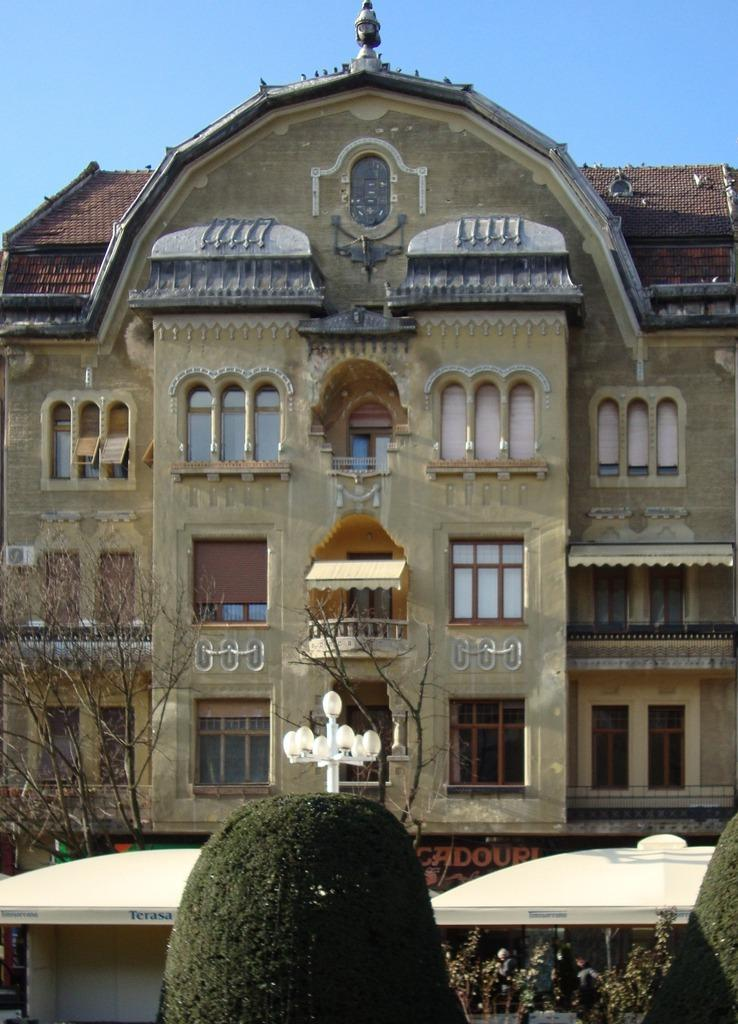

In [35]:
image = ds['test'][23]['pixel_values']
image

#### Prepare Image & Apply Model to It

In [48]:
# prep image for model
encoding = image_processor(image, return_tensors="pt")
pixel_values = encoding.pixel_values
print(pixel_values.shape)
outputs = model(pixel_values=pixel_values)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 3, 512, 512])
torch.Size([1, 13, 128, 128])


#### Define Function to Convert Segments to Their Respective Colors

In [51]:
def color_map(): 
    return [
    [  0,   0,   0],
    [  0,   0, 170],
    [  0,   0, 255],
    [  0,  85, 255],
    [  0, 170, 255],
    [  0, 255, 255],
    [ 85, 255, 170],
    [170,   0,   0],
    [170, 255,  85],
    [255,   0,   0],
    [255,  85,   0],
    [255, 170,   0],
    [255, 255,   0]]

#### Process Image & Mask, Then Display It

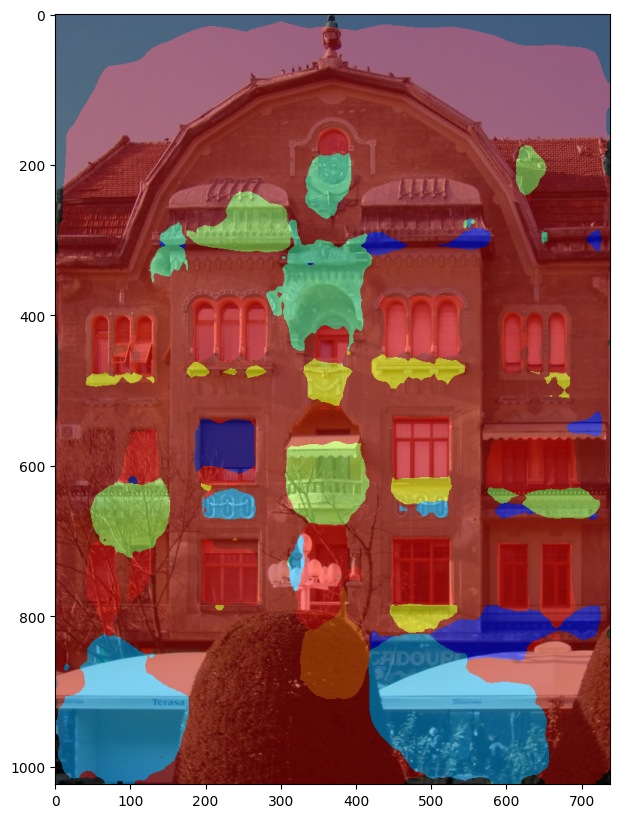

In [55]:
# First, rescale logits to original image size
upsampled_logits = torch.nn.functional.interpolate(logits,
                size=image.size[::-1],
                mode='bilinear',
                align_corners=False)

# Second, apply argmax on the class dimension
segments = upsampled_logits.argmax(dim=1)[0]
color_seg = np.zeros((segments.shape[0], segments.shape[1], 3), dtype=np.uint8) #in the form of: height, width, 3
palette = np.array(color_map())
for label, color in enumerate(palette):
    color_seg[segments == label, :] = color
color_seg = color_seg[..., ::-1]

# Show image with mask over it
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

### Notes & Other Takeaways From This Project
****
- This is not the result I was looking for. I am going to try to better tune the hyperparameters and retune this project. 

****

### Citations

- Model Checkpoint
    > @article{DBLP:journals/corr/abs-2105-15203, author = {Enze Xie and Wenhai Wang and Zhiding Yu and Anima Anandkumar and Jose M. Alvarez and Ping Luo}, title = {SegFormer: Simple and Efficient Design for Semantic Segmentation with Transformers}, journal = {CoRR}, volume = {abs/2105.15203}, year = {2021}, url = {https://arxiv.org/abs/2105.15203}, eprinttype = {arXiv}, eprint = {2105.15203}, timestamp = {Wed, 02 Jun 2021 11:46:42 +0200}, biburl = {https://dblp.org/rec/journals/corr/abs-2105-15203.bib}, bibsource = {dblp computer science bibliography, https://dblp.org}}

- Dataset
    > @INPROCEEDINGS{Tylecek13, author = {Radim Tyle{\v c}ek and Radim {\v S}{\' a}ra}, title = {Spatial Pattern Templates for Recognition of Objects with Regular Structure}, booktitle = {Proc. GCPR}, year = {2013}, address = {Saarbrucken, Germany},}